In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random, copy
import time
from scipy.interpolate import make_interp_spline

## Exercice 01:

### 1.a Une structure de données pour représenter un multigraphe par une matrice d'adjacence.

- Le multi graphe G est représenté par une matrice d'adjacence.
- Pour réaliser l'opération de contraction d'une arête (i,j), on réalise les traitements suivants
sur la matrice d'adjacence représentant le graphe G:<br>
    - Ajouter à la ligne et colonne du sommet i, la ligne et colonne du sommmet j. Cette étape permet de relier tous les sommets voisins de j au sommet i (afin d'en garder qu'un seul, et c'est le but de la contraction). <br>
    - Supprimer la ligne et la colonne correspondants au sommet j (car a été fusionné avec le sommet i pour construire un nouvel ensemble) (La suppresion se fait en remplaçant la ligne et la colonne j par -1 dans la matrice d'adjacence).

In [3]:
def contract(A,i,j):
    """
    Realise the contraction in the graph M represented by its adjancency matrix
    """
    li = A[i,:]
    lj = A[j,:]
    ci = A[:,i]
    cj = A[:,j]

    A[i,:] = li + lj
    A[:,i] = ci + cj

    A[i,i] = 0

    A[j,:] = -1
    A[:,j] = -1
    
    return A

### Complexité :
L'opération de contraction présentée ci-dessus se fait en temps constant O(n).

En effet, il s'agit juste de remplacer deux lignes et deux colonnes connus de la matrice d'adjacence M par des valeurs, donc il suffit de parcourir toute la ligne/colonne et d'assigner les nouvelles valeurs, ce qui se fait en temps O(n).

### 1.b Creation de familles de graphes.

Module de création de graphe (par génération de matrices d'adjacences et de listes d'adjacence pour la deuxième représentation), servira pour la partie experimentale et analyse de la complexité.

Les familles de graphes crées par ce module sont :
- Graphe aléatoires : On ajoute une arête en deux sommets i et j suivant une probabilité p.
- Graphes complets à n sommets.
- Graphes bipartis complets à n=2k sommets.
- Graphes cycliques avec des cycles de n sommets.
- Graphes construits dont on connait la taille d'une coupure minimum (1).

In [207]:
def create_graph(n_vertex,ty = "random", rep="M"):
    shape = (n_vertex,n_vertex)
    def list_adj(M):
        L = {i+1:[] for i in range(n_vertex)}
        for i in range(M.shape[0]):
            for j in range(M.shape[1]):
                if M[i,j] == 1:
                    L[i+1].append(j+1)
        return L
    
    if ty=="random":
        # how to create a random graph
        # add an edge with probability p
        p = [0.2,0.7] # To be verified
        M = np.zeros(shape)
        for i in range(n_vertex):
            for j in range(n_vertex):
                e = np.random.choice([0,1],1,[p])
                M[i,j] = e
                M[j,i] = e
        np.fill_diagonal(M,0)
    elif ty=="complete":
        M = np.ones(shape)
        np.fill_diagonal(M,0)
    elif ty=="biparti":
        n = n_vertex//2
        A = np.concatenate((np.zeros((n,n)), np.ones((n,n))), axis=0)
        B = np.concatenate((np.ones((n,n)), np.zeros((n,n))), axis=0)
        M = np.concatenate((A,B), axis=1)
        
    elif ty=="cyclique":
        M = np.zeros(shape)
        for i in range(n_vertex-1):
            M[i,i+1] = 1
        M[0,n_vertex-1] = 1
        for i in range(n_vertex):
            for j in range(n_vertex):
                M[j,i] = M[i,j]
    
    elif ty=="card_one":
        p = [0.2,0.8] # To be verified
        M = np.zeros(shape)
        for i in range(n_vertex-1):
            for j in range(n_vertex-1):
                e = np.random.choice([0,1],1,[p])
                M[i,j] = e
                M[j,i] = e
        
        a = np.random.randint(n_vertex-1)
        M[n_vertex-1,a] = 1
        M[a,n_vertex-1] = 1
        
        
        np.fill_diagonal(M,0)
    
    else:
        print('enter a valid graph type')
        return
    
    if rep=="L":
        return list_adj(M.astype(int))
    return M.astype(int)

In [160]:
G_random = create_graph(8,ty="random")
G_random

{1: [4, 7],
 2: [5, 6],
 3: [4, 8],
 4: [1, 3, 5, 8],
 5: [2, 4, 6, 8],
 6: [2, 5, 8],
 7: [1, 8],
 8: [3, 4, 5, 6, 7]}

In [162]:
G_complete = create_graph(8,ty="complete")
G_complete

array([[0, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 0, 1, 1, 1, 1, 1],
       [1, 1, 1, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 0, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 0]])

In [73]:
G_biparti = create_graph(8,ty="biparti")
G_biparti

array([[0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0]])

In [74]:
G_cyclique = create_graph(8,ty="cyclique")
G_cyclique

array([[0, 1, 0, 0, 0, 0, 0, 1],
       [1, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 1],
       [1, 0, 0, 0, 0, 0, 1, 0]])

In [75]:
G_cardone = create_graph(8,ty="card_one")
G_cardone

array([[0, 1, 0, 1, 1, 0, 1, 0],
       [1, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 0, 0],
       [1, 0, 1, 1, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0]])

### 1.c Tirage aléatoire d'une arête à l'étape t de l'algorithme de Karger.

le graphe G est possiblement devenu un multi-graphe avec plusieurs arêtes entre deux sommets.
Dans notre analyse théorique de la complexité de l'algorithme de Karger, nous avons supposée
que l'arêtes e de l'opération de sélection aléeatoire dans la boucle tant que est
tirée uniformement aléatoirement parmi toutes les arêtes possibles. 

Pour effectuer ce tirage aléatoire lorsque le multi-graphe G est représenté par une matrice d'adjacence, on réalise les étapes suivantes :

Etant donnée une liste somme_ligne de tailles nombre de sommets dans le graphe G, et contenant dans chaque case le nombre de sommmets par ligne dans la matrice d'adjacence :

Exemple :

Pour la matrice  $\begin{bmatrix}
0 & 1 & 1\\ 
1 & 0 & 1\\ 
1 & 0 & 0
\end{bmatrix}$ on retrouve la liste : $\begin{bmatrix}
2 & 2 & 1
\end{bmatrix}$

### Complexité:

Donc, pour choisir aléatoirement selon une loi uniforme une arête parmi toutes les arêtes du graphe, on tire un nombre aléatoire entre 1 et le nombre d'arêtes du graphe G (qui n'est rien d'autre que la somme des éléments de la liste sommme_liste).

Soit a le numéro de l'arête qu'on a tiré précédemment, en utilisant la somme cummulée des éléments de la liste somme_ligne, on peut reperer la ligne ou se trouve cette arête. Cette étape se réalise en temps linéaire O(n) dans le pire des cas.

De même pour la colonne, on fait la somme cummulé et on retrouve le numéro de colonne. Cette étape se réalise également en temps linéaire O(n) dans le pire des cas.

A la fin de cette procédure, on retourne une l'indice de l'arête (i,j) tiré aléatoirement du graphe G en temps linéaire.


In [208]:
# Implémentation de la fonction de tirage aléatoire d'arête
# Random choice
def arrete_choice(M, sum_lines) :
    """
    Chooses a random edge from the multi graph G
    represented by its adjacency matrix
        M : Adjacency matrix
        somme_ligne : list containing number of edges per line in M
    returns :
        M[i,j],i,j
    """
    # Pick up up a random number of edge
    nb_arrete = np.sum(sum_lines)
    
    random_arrete = np.random.randint(nb_arrete)
    
    # Find in linear time the line index of that edge
    cumul = 0
    for i in range(len(sum_lines)) :
        cumul += sum_lines[i]
        if cumul > random_arrete :
            break
    
    # Find in linear time the column index of that edge
    j = random_arrete - (cumul - sum_lines[i])
    cumul = 0
    for k in range(M.shape[1]) :
        cumul += M[i,k] if M[i,k]>0 else 0
        if cumul > j :
            break

    return M[i,k],i,k

### 1.d Implémentation de l'algorithme de Karger.
Une première implémentation de l'algorithme de Karger sur un graphe représenté par une matrice d'adjacence.

In [10]:
def Karger(M, verbose= False, card = True) :
    # Show the resulting list
    def print_fusion(fusion):
        for i in range(len(fusion)):
            if len(fusion[i])>0:
                print(fusion[i])
    
    # Init
    A = M.copy()
    fusion = [[i] for i in range(A.shape[0])]
    
    
    sum_lines = np.sum(A,axis=1)
    nb_vertex = A.shape[0]
    
    if verbose: 
        print("---")
        print("DEBUG")
        print("---")
        print(A)
        print(sum_lines)
    # While the number of vertex is higher than 2
    while nb_vertex > 2 :
        # An inner loop to avoid choosing an edge that has
        # a negative value in the adjacency matrix
        # This is taking a lot of time when the matrix is high dimensional
        if sum(sum_lines)==0:
            break
        while True :
            val,i,j = arrete_choice(A, sum_lines)
            if val>0:
                break
        # realises a contraction on the edge (i,j)
        A = contract(A,i,j)
        
        ## Update of the data structures
        
        # Append the merged vertex
        for e in fusion[j]:
            fusion[i].append(e)
        fusion[j] = []
        
        # Update the sum_lines list
        #sum_lines[i] += sum_lines[j] - val
        sum_lines[i] += sum_lines[j]
        sum_lines[i] -= 2*val
        sum_lines[j] = 0
        # We have merged two vertex
        nb_vertex-=1
        # Log
        if verbose:
            print(i,j)
            print(A)
            print("sommets: ",nb_vertex)
            print("somme ligne :", sum_lines)
            
    if verbose :
        print_fusion(fusion)
    
    S = []
    for i in range(len(fusion)):
        if len(fusion[i])>0:
            S.append(fusion[i])
    
    try:
        len_cut = A[A>0][0]
    except:
        len_cut = 0
    
    if card:
        return S[0], len_cut
    return S[0]


In [11]:
S, cut = Karger(M)
print("S1 :", S)
print("The cut returned by Karger Algorithm :", cut)

S1 : [0]
The cut returned by Karger Algorithm : 2


In [12]:
S, cut = Karger(G_complete)
print("S1 :", S)
print("The cut returned by Karger Algorithm :", cut)

S1 : [3]
The cut returned by Karger Algorithm : 7


In [13]:
S, cut = Karger(G_biparti)
print("S1 :", S)
print("The cut returned by Karger Algorithm :", cut)

S1 : [2]
The cut returned by Karger Algorithm : 4


In [16]:
S, cut = Karger(G_cyclique)
print("S1 :", S)
print("The cut returned by Karger Algorithm :", cut)

S1 : [2, 0, 1, 7, 6, 3]
The cut returned by Karger Algorithm : 2


In [17]:
S, cut = Karger(G_cyclique)
print("S1 :", S)
print("The cut returned by Karger Algorithm :", cut)

S1 : [2, 3, 4, 6, 0, 7, 1]
The cut returned by Karger Algorithm : 2


In [18]:
# Cas de garphe ou le card de la coupe min est 0
M = np.array([[0, 0, 0, 0, 1, 1, 1, 0],
              [0, 0, 0, 1, 1, 0, 1, 0],
              [0, 0, 0, 1, 0, 1, 0, 0],
              [0, 1, 1, 0, 0, 1, 0, 0],
              [1, 1, 0, 0, 0, 0, 0, 0],
              [1, 0, 1, 1, 0, 0, 0, 0],
              [1, 1, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0]])

S, cut = Karger(M)
print("S1 :", S)
print("The cut returned by Karger Algorithm :", cut)

S1 : [6, 1, 4, 2, 3, 5, 0]
The cut returned by Karger Algorithm : 0


In [22]:
# Cas de graphe avec deux arêtes seulement
M = np.array([[0, 0, 0, 0, 0],
              [0, 0, 1, 0, 0],
              [0, 1, 0, 1, 0],
              [0, 0, 1, 0, 0],
              [0, 0, 0, 0, 0]])

S, cut = Karger(M)
print("S1 :", S)

S1 : [0]


### Complexité:
La complexité théorique de l'algorithme de Karger vue en cours est de l'ordre de O(n²) pour une représentation par matrice d'adjacence.

Par la suite, nous allons essayer de retrouver la même complexité en utilisant une approche expérimentale.

---

In [209]:
# Fonction utile pour le rescaling des axes pour l'affichage


from matplotlib.ticker import NullFormatter, FixedLocator

def scale_applying(x,y):
    # Fixing random state for reproducibility
    np.random.seed(19680801)

    # plot with various axes scales
    fig, axs = plt.subplots(3, 2, figsize=(6, 8),
                            constrained_layout=True)
    """
    # linear
    ax = axs[0, 0]
    ax.plot(x, y)
    ax.set_yscale('linear')
    ax.set_title('linear')
    ax.grid(True)


    # log
    ax = axs[0, 1]
    ax.plot(x, y)
    ax.set_yscale('log')
    ax.set_title('log')
    ax.grid(True)


    # symmetric log
    ax = axs[1, 1]
    ax.plot(x, y - y.mean())
    ax.set_yscale('symlog', linthresh=0.02)
    ax.set_title('symlog')
    ax.grid(True)

    # logit
    ax = axs[1, 0]
    ax.plot(x, y)
    ax.set_yscale('logit')
    ax.set_title('logit')
    ax.grid(True)


    # Function x**(1/2)
    def forward(x):
        return x**(1/2)


    def inverse(x):
        return x**2


    ax = axs[2, 0]
    ax.plot(x, y)
    ax.set_yscale('function', functions=(forward, inverse))
    ax.set_title('function: $x^{1/2}$')
    ax.grid(True)
    ax.yaxis.set_major_locator(FixedLocator(np.arange(0, 1, 0.2)**2))
    ax.yaxis.set_major_locator(FixedLocator(np.arange(0, 1, 0.2)))
    """
    


    # Function Mercator transform
    def forward(a):
        a = np.deg2rad(a)
        return np.rad2deg(np.log(np.abs(np.tan(a) + 1.0 / np.cos(a))))


    def inverse(a):
        a = np.deg2rad(a)
        return np.rad2deg(np.arctan(np.sinh(a)))

    ax = axs[2, 1]

    t = np.arange(0, 170.0, 0.1)
    s = t / 2.

    ax.plot(t, s, '-', lw=2)

    ax.set_yscale('function', functions=(forward, inverse))
    ax.set_title('function: Mercator')
    ax.grid(True)
    ax.set_xlim([0, 180])
    ax.yaxis.set_minor_formatter(NullFormatter())
    ax.yaxis.set_major_locator(FixedLocator(np.arange(0, 90, 10)))

    plt.show()

### Analyse de la complexité de l'algorithme de Karger implémenté en utilisant une représentation par matrice d'adjacence

#### Schéma expérimental:
- Génération aléatoire d'exemple de taille différente
- Exécution de l'algorithme de Karger sur les instances générés
- Evaluation du temps d'exécution obtenu

In [164]:
# Cas de graphe complet à n sommets
exec_times = []
for n in range(5, 100, 1):
    t = 0
    for it in range(100):
        G = create_graph(n, ty="complete")
        tic = time.time()
        _,_ = Karger(G)
        tac = time.time()
        t+= (tac-tic)
    exec_times.append(t/n)

# Plot the execution time
x_c = np.arange(5,100,1)
y_c = np.array(exec_times)

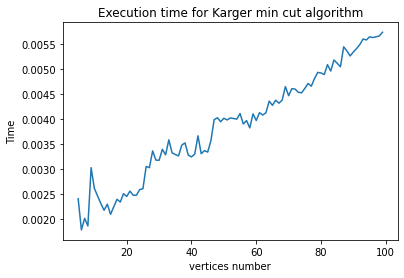

In [165]:
plt.plot(x_c,y_c)
# Add titles and labels
plt.title('Execution time for Karger min cut algorithm')
plt.xlabel('vertices number')
plt.ylabel('Time')

# Show the figure
plt.show()

In [166]:
# Cas de graphe biparti à n sommets
exec_times = []
for n in range(5, 100, 1):
    t = 0
    for it in range(100):
        G = create_graph(n, ty="biparti")
        tic = time.time()
        _,_ = Karger(G)
        tac = time.time()
        t+= (tac-tic)
    exec_times.append(t/n)

# Plot the execution time
x_b = np.arange(5,100,1)
y_b = np.array(exec_times)

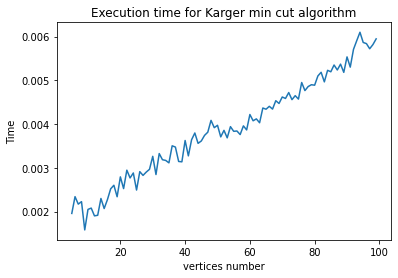

In [167]:
plt.plot(x_b,y_b)
# Add titles and labels
plt.title('Execution time for Karger min cut algorithm')
plt.xlabel('vertices number')
plt.ylabel('Time')

# Show the figure
plt.show()

In [168]:
# Cas de graphe complet à n sommets
exec_times = []
for n in range(5, 100, 1):
    t = 0
    for it in range(20):
        G = create_graph(n, ty="random")
        tic = time.time()
        _,_ = Karger(G)
        tac = time.time()
        t+= (tac-tic)
    exec_times.append(t/n)

# Plot the execution time
x_r = np.arange(5,100,1)
y_r = np.array(exec_times)

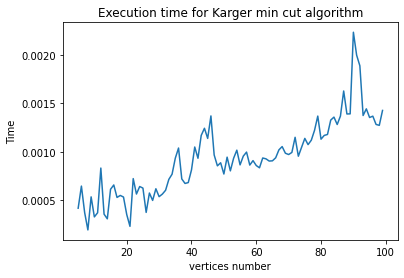

In [169]:
plt.plot(x_r,y_r)
# Add titles and labels
plt.title('Execution time for Karger min cut algorithm')
plt.xlabel('vertices number')
plt.ylabel('Time')

# Show the figure
plt.show()

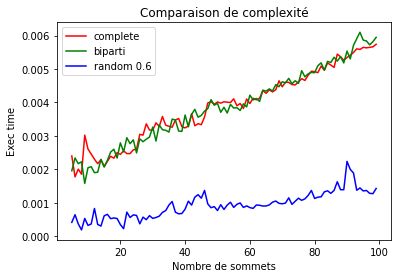

In [170]:
# Analyse des perf sur les familles de graphes

# Plotting both the curves simultaneously
plt.plot(x_c, y_c, color='r', label='complete')
plt.plot(x_b, y_b, color='g', label='biparti')
plt.plot(x_r, y_r, color='b', label='random 0.6')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Nombre de sommets")
plt.ylabel("Exec time")
plt.title("Comparaison de complexité")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()

In [171]:
exec_times = []
for n in range(5, 101, 1):
    t = 0
    type_ = np.random.choice(['complete','random','biparti','cyclique'],1)
    for it in range(40):
        G = create_graph(n, ty=type_)
        tic = time.time()
        _,_ = Karger(G)
        tac = time.time()
        t+= (tac-tic)
    exec_times.append(t/n)

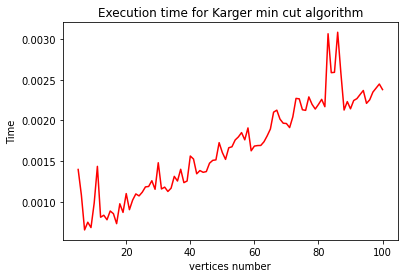

In [172]:
# Plotting the execution time
x = np.arange(5, 101, 1)
y = np.array(exec_times)

plt.plot(x,y, "r")

# Add titles and labels
plt.title('Execution time for Karger min cut algorithm')
plt.xlabel('vertices number')
plt.ylabel('Time')

# Show the figure
plt.show()

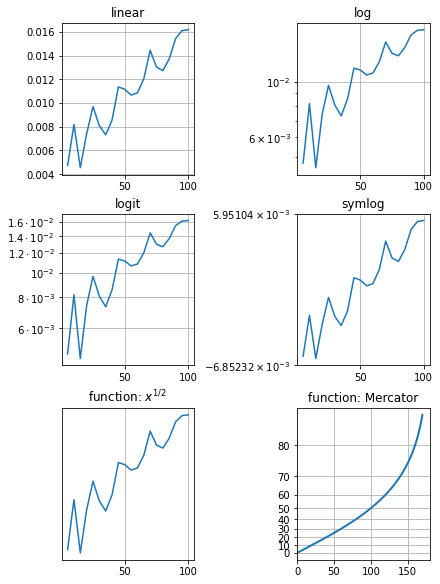

In [96]:
scale_applying(x,y)

### Analyse de la complexité expérimentale obtenu:
On remarque sur les différents graphe obtenus que le temps d'exécution de l'algorithme de Karger pour les graphes représentés par une matrice d'adjacence est linéaire (de l'ordre de O(n²) ie quadratique), ce qui confirme la complexité théorique annoncée dans le cours.

L'algorithme de Karger n'est pas sensible aux différente familles de graphes.

### 1.e Proposition d'une deuxième structure de données pour la représentation des graphes.

La deuxième structure de données pour laquelle nous avons opté est la représentation par liste d'adjacence.

In [210]:
def choose_random_key(G):
    while True:
        a = random.choice(list(G.keys()))  # picks a random vertex
        if len(G[a])>0:
            break
    b = random.choice(list(G[a]))      # picks a random edge in the adjacency list
    return a, b

def contract_2(G,a,b):
    """
    Complexité de cet algorithme Linéaire en O(n²)
    """
    # Contraction in the case of list of adjacency representation
    G[a].extend(G[b])  # copies all items Linear time
    
    for x in G[b]:
        G[x].remove(b)  # remove the other occurrences of b in adjacency list
        G[x].append(a)  # tell them to look at a instead

    while a in G[a]:
        G[a].remove(a)  # remove self loops

    del G[b]  # getting rid of the empty vertex from the adj list
    
    return G


def Karger_2(G):
    
    A = G.copy()
    
    S = dict.fromkeys(A.keys(),[])
    S2 = []
    while len(A) > 2:
        a, b = choose_random_key(A)  # the nodes that are part of the random edge
        
        A = contract_2(A,a,b)
        
        S[a].append(b)

    S2.append(a)
    S2 = S2 + S[a]
    
    return S2,len(A[a])

### 1.f

Pour effectuer le tirage aléatoire en dans le cas d'une représentation du graphe G avec une liste d'adjacence, il suffit de choisir aléatoirement de manière uniforme une clé (ie un sommet) parmi les sommets du graphe (ceci se fait en temps linaire), de même on accède à la liste d'adjacence du sommet selectionné (en temps constant), puis on tire aléatoirement un sommet dans cette liste (en temps linéaire également).

Donc la complexité de l'opération du tirage aléatoire d'une arête pour la contraction est de l'ordre de O(n).

### 1.g Analyse de la complexité théorique de l’algorithme avec liste d'adjacence

La complexité théorique de l'algorithme de Karger adapté au cas de représentation du graphe par liste d'adjacence est cubique de l'ordre de O(n3).

En effet, dans chaque itération de la boucle (while nb_sommets>2) on réalise une opération de choix de l'arête (O(n)) en plus d'une opération de contraction.

La contraction de l'arête choisie se fait en temps quadratique O(n²) du fait de copier tout les éléments du deuxième sommet de l'arête dans la liste d'adjacence du premier sommet de l'arête.

On réitère ce processus (n-2) fois, donc on obtient une complexité temporelle en O(n3)

### 1.h Analyse expérimentale de la complexité :

In [211]:
# Cas de graphe complet à n sommets
exec_times = []
for n in range(5, 100, 1):
    t = 0
    for it in range(10):
        G = create_graph(n,'complete',rep='L')
        tic = time.time()
        _,_ = Karger_2(G)
        tac = time.time()
        t+= (tac-tic)
    exec_times.append(t/n)

# Plot the execution time
x_c2 = np.arange(5,100,1)
y_c2 = np.array(exec_times)

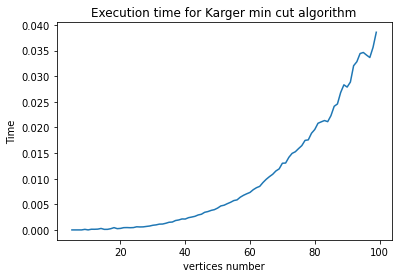

In [212]:
plt.plot(x_c2,y_c2)
# Add titles and labels
plt.title('Execution time for Karger min cut algorithm')
plt.xlabel('vertices number')
plt.ylabel('Time')

# Show the figure
plt.show()

In [201]:
# Cas de graphe complet à n sommets
exec_times = []
for n in range(5, 100, 1):
    t = 0
    G = create_graph(n,ty='random',rep='L')
    tic = time.time()
    _,_ = Karger_2(G)
    tac = time.time()
    t+= (tac-tic)
    exec_times.append(t/n)

# Plot the execution time
x_r2 = np.arange(5,100,1)
y_r2 = np.array(exec_times)

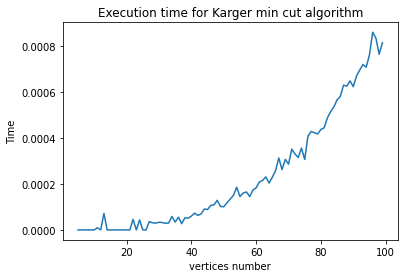

In [202]:
# Plot the execution time
plt.plot(x_r2,y_r2)
# Add titles and labels
plt.title('Execution time for Karger min cut algorithm')
plt.xlabel('vertices number')
plt.ylabel('Time')

# Show the figure
plt.show()

In [197]:
# Cas de graphe complet à n sommets
exec_times = []
for n in range(5, 100, 1):
    t = 0
    for it in range(20):
        G = create_graph(n,ty='biparti',rep='L')
        tic = time.time()
        _,_ = Karger_2(G)
        tac = time.time()
        t+= (tac-tic)
    exec_times.append(t/n)

# Plot the execution time
x_b2 = np.arange(5,100,1)
y_b2 = np.array(exec_times)

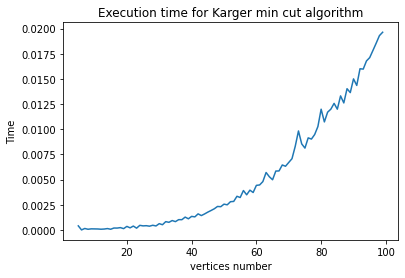

In [198]:
# Plot the execution time
plt.plot(x_b2,y_b2)
# Add titles and labels
plt.title('Execution time for Karger min cut algorithm')
plt.xlabel('vertices number')
plt.ylabel('Time')

# Show the figure
plt.show()

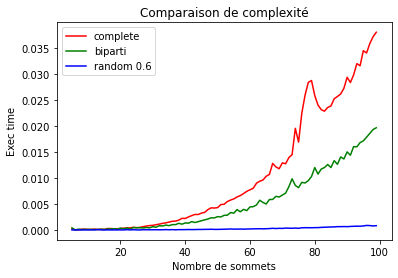

In [203]:
# Analyse des perf sur les familles de graphes

# Plotting both the curves simultaneously
plt.plot(x_c2, y_c2, color='r', label='complete')
plt.plot(x_b2, y_b2, color='g', label='biparti')
plt.plot(x_r2, y_r2, color='b', label='random 0.6')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Nombre de sommets")
plt.ylabel("Exec time")
plt.title("Comparaison de complexité")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()

### Comparaison entre les deux représentations du graphe:
Les deux représentations ont été testé sur un même nombre d'exemples et sur les même paramètres (nombre de sommets générés et nombre d'instances pour chaque nombre).

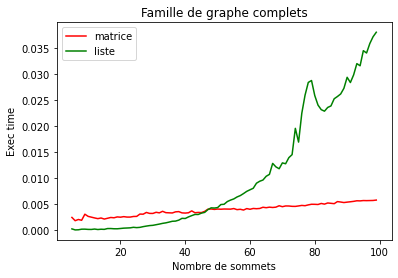

In [204]:
# Plotting both the curves simultaneously
plt.plot(x_c, y_c, color='r', label='matrice')
plt.plot(x_c2, y_c2, color='g', label='liste')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Nombre de sommets")
plt.ylabel("Exec time")
plt.title("Famille de graphe complets")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

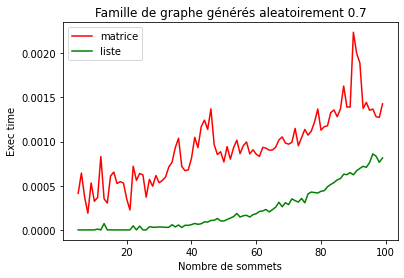

In [205]:
# Plotting both the curves simultaneously
plt.plot(x_r, y_r, color='r', label='matrice')
plt.plot(x_r2, y_r2, color='g', label='liste')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Nombre de sommets")
plt.ylabel("Exec time")
plt.title("Famille de graphe générés aleatoirement 0.7")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

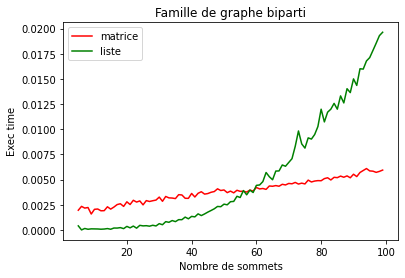

In [206]:
# Plotting both the curves simultaneously
plt.plot(x_b, y_b, color='r', label='matrice')
plt.plot(x_b2, y_b2, color='g', label='liste')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Nombre de sommets")
plt.ylabel("Exec time")
plt.title("Famille de graphe biparti")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

On voit clairement sur les graphes que la représentation par une matrice d'adjacence résulte d'une complexité temporelle réduite que celle avec une liste d'adjacence.

### 1.i (Bonus) Adaptation de l'algorithme de Karger au cas des graphes non orientés et pondérés.

### Intuition:

Il s'agit, pour cette variante du problème de la coupe minimum de choisir de trouver la coupe ayant le poids minimal. Pour y faire, il faut que le choix aléatoire d'arêtes favorise celles ayant un poid élevé, puis le reste des arêtes.

Donc l'adaptation faite sur l'algorithme de Karger est au niveau du choix de l'arête, ou il se fait suivant une loi de probabilité pour chaque arête d'être selectionné.

In [20]:
def edge_choice(G,W):
    rng = np.random.choice(a = np.arange(G.shape[0]*G.shape[0]), p = np.ndarray.flatten(W/np.sum(W)))
    i = int(rng/G.shape[0])
    j = rng%G.shape[0]
    
    return i,j

M = np.array([[0,1,1,0,0,0],
              [1,0,0,1,1,0],
              [1,0,0,1,0,0],
              [0,1,1,0,1,0],
              [0,1,0,1,0,1],
              [0,0,0,0,1,0]])

W = np.array([[0,3,1,0,0,0],
              [3,0,0,1,1,0],
              [1,0,0,10,0,0],
              [0,1,10,0,1,0],
              [0,1,0,1,0,20],
              [0,0,0,0,20,0]])


i,j = edge_choice(M,W)
print(W[i,j],i,j)

20 5 4


In [21]:
def Karger_p(M,P, verbose= False, len_cut = True) :
    # Show the resulting list
    def print_fusion(fusion):
        for i in range(len(fusion)):
            if len(fusion[i])>0:
                print(fusion[i])
    
    # Init
    A = M.copy()
    W = P.copy()
    
    fusion = [[i] for i in range(A.shape[0])]
    
    
    sum_lines = np.sum(A,axis=1)
    nb_vertex = A.shape[0]
    
    if verbose:
        print("---")
        print("DEBUG")
        print("---")
        print(A)
        print(sum_lines)
    # While the number of vertex is higher than 2
    while nb_vertex > 2 :
        # An inner loop to avoid choosing an edge that has
        # a negative value in the adjacency matrix
        # This is taking a lot of time when the matrix is high dimensional
        i,j = edge_choice(A,W)
        val = A[i,j]

        # realises a contraction on the edge (i,j)
        A = contract(A,i,j)
        
        ## Update of the data structures
        # Update of the weights
        li = W[i,:]
        lj = W[j,:]
        ci = W[:,i]
        cj = W[:,j]

        W[i,:] = li + lj
        W[:,i] = ci + cj

        W[i,i] = 0

        W[j,:] = 0
        W[:,j] = 0
        
        
        # Append the merged vertex
        for e in fusion[j]:
            fusion[i].append(e)
        fusion[j] = []
        
        W[i,j] = 0
        W[j,i] = 0
        
        # Update the sum_lines list
        #sum_lines[i] += sum_lines[j] - val
        sum_lines[i] += sum_lines[j]
        sum_lines[i] -= 2*val
        sum_lines[j] = 0
        # We have merged two vertex
        nb_vertex-=1
        # Log
        if verbose:
            print(i,j)
            print(A)
            print("sommets: ",nb_vertex)
            print("somme ligne :", sum_lines)
            
    if verbose :
        print_fusion(fusion)
    
    S = []
    for i in range(len(fusion)):
        if len(fusion[i])>0:
            S.append(fusion[i])
    try:
        coupure = A[A>0][0]
    except:
        coupure = 0
    weight = W[W>0][0]
        
    if len_cut:
        return S[0], coupure, weight
    return S[0]

# I think I found the bug
# In fact, I shouldn't be choosing the points where 
# the line/column has already been "removed" or put to -1

In [22]:
Karger_p(M,W)

([0], 2, 4)

-------

---

## Exercice 02:

### 2.a  étude expérimentale de la probabilité de succès
<b>Réalisation d'une étude expérimentale de la probabilité de succés des implémentations de l'exercice 01</b>

L'étude consiste à exécuter plusieurs fois l'algorithme de Karger implémenté en question 01 sur des familles de graphes différentes et pour lesquelles on connait la taille d'une coupe minimale, et de calculer la probabilité de succès de l'algorithme.

Prenons l'exemple du graphe G suivant représenté par sa matrice d'adjacence M :

$\begin{bmatrix}
0 & 1 & 1 & 0 & 0 & 0\\ 
1 & 0 & 0 & 1 & 1 & 0\\ 
1 & 0 & 0 & 1 & 0 & 0\\
0 & 1 & 1 & 0 & 1 & 0\\ 
0 & 1 & 0 & 1 & 0 & 1\\ 
0 & 0 & 0 & 0 & 1 & 0
\end{bmatrix}$

La taille de la coupe minimale est : 1

Cette coupe correspond aux deux sous ensembles de sommets {1,2,3,4,5} et {6}

Prenons l'exemple du graphe M2 (vu en cours) suivant représenté par sa matrice d'adjacence M :

$\begin{bmatrix}
0 & 1 & 1 & 1 & 0 & 0 & 0 & 0 \\
1 & 0 & 1 & 1 & 1 & 0 & 0 & 0 \\
1 & 1 & 0 & 1 & 1 & 0 & 0 & 0 \\
1 & 1 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 1 & 0 & 0 & 1 & 1 & 1 \\
0 & 0 & 0 & 0 & 1 & 0 & 1 & 1 \\
0 & 0 & 0 & 0 & 1 & 1 & 0 & 1 \\
0 & 0 & 0 & 0 & 1 & 1 & 1 & 0
\end{bmatrix}$

La taille de la coupe minimale est : 2

Cette coupe correspond aux deux sous ensembles de sommets {1,2,3,4} et {5,6,7,8}

### Quelques graphes pour lesquels la taille d'une coupe min est connue:

G_random : Taille d'une coupe minimale dépend du graphe.

G_complete : Taille d'une coupe minimale est le nombre de sommets -1 (n-1)

G_biparti : Taille d'une coupe minimale est le nombre de sommets divisé par 2 (n/2)

G_cyclique : Taille d'une coupe minimale est 2 (reste à vérifier)

G_cardone : Taille d'une coupe minimale est 1 (graphe construit avec un sommet ayant un seul sommet voisin).

#### La probabilité de succès théorique:
On a vu en cours que la probabilité de succès de l'algorithme de Karger est : >= 2/n(n-1)

In [214]:
# Une fonction qui calcule la probabilité de succès de plusieurs itérations T de l'algorithme de Karger

def p_succes(G, min_cut, T=1000):
    n = 0
    for i in range(T):
        _, m = Karger(G)
        n += 1 if m==min_cut else 0
    return round(n/T,2)

In [31]:
M = np.array([[0,1,1,0,0,0],
              [1,0,0,1,1,0],
              [1,0,0,1,0,0],
              [0,1,1,0,1,0],
              [0,1,0,1,0,1],
              [0,0,0,0,1,0]])

M2 = np.array([[0,1,1,1,0,0,0,0],
               [1,0,1,1,1,0,0,0],
               [1,1,0,1,1,0,0,0],
               [1,1,1,0,0,0,0,0],
               [0,1,1,0,0,1,1,1],
               [0,0,0,0,1,0,1,1],
               [0,0,0,0,1,1,0,1],
               [0,0,0,0,1,1,1,0]])

In [34]:
r = p_succes(G_complete, G_complete.shape[0]-1)
print(f'La probabilité de succès théorique minimale est: {2/(G_complete.shape[0]*(G_complete.shape[0]-1))}')
print(f'La probabilité de succès expetim obtenue    est: {r}')

La probabilité de succès théorique minimale est: 0.03571428571428571
La probabilité de succès expetim obtenue    est: 0.7


In [35]:
r = p_succes(G_biparti, G_biparti.shape[0]/2)
print(f'La probabilité de succès théorique minimale est: {2/(G_biparti.shape[0]*(G_biparti.shape[0]-1))}')
print(f'La probabilité de succès expetim obtenue    est: {r}')

La probabilité de succès théorique minimale est: 0.03571428571428571
La probabilité de succès expetim obtenue    est: 0.63


In [215]:
r = p_succes(G_cardone, 1)
print(f'La probabilité de succès théorique minimale est: {2/(G_cardone.shape[0]*(G_cardone.shape[0]-1))}')
print(f'La probabilité de succès expetim obtenue    est: {r}')

La probabilité de succès théorique minimale est: 0.03571428571428571
La probabilité de succès expetim obtenue    est: 0.61


Sur les 03 graphes présentés la borne inférieure de la probabilité de succès de l'algorithme est vérifiée.

### Etude expérimentale de la probabilité de succès

In [219]:
# Cas de graphe complet à n sommets
succes = []
for n in range(5, 60, 1):
    G = create_graph(n,'complete')
    succes.append(p_succes(G,min_cut=G.shape[0]-1))

# Plot the execution time
x_cs = np.arange(5,60,1)
y_cs = np.array(succes)

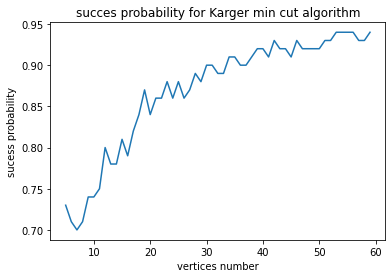

In [220]:
plt.plot(x_cs,y_cs)
# Add titles and labels
plt.title('succes probability for Karger min cut algorithm')
plt.xlabel('vertices number')
plt.ylabel('sucess probability')
# Show the figure
plt.show()

On remarque à partir de la figure générée que la borne inférieure théorique vu en cours est respectée.

In [222]:
# Cas de graphe complet à n sommets
succes = []
for n in range(4, 60, 2):    
    G = create_graph(n,'biparti')
    succes.append(p_succes(G,min_cut=G.shape[0]/2))
    
x_bs = np.arange(4,60,2)
y_bs = np.array(succes)

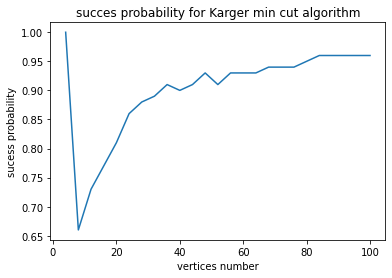

In [43]:
# Plot the execution time
plt.plot(x_bs,y_bs)
# Add titles and labels
plt.title('succes probability for Karger min cut algorithm')
plt.xlabel('vertices number')
plt.ylabel('sucess probability')

# Show the figure
plt.show()

In [223]:
# Cas de graphe complet à n sommets
succes = []
for n in range(5, 60, 1):    
    G = create_graph(n,'card_one')
    succes.append(p_succes(G,min_cut=1))
    
x_os = np.arange(5,60,1)
y_os = np.array(succes)

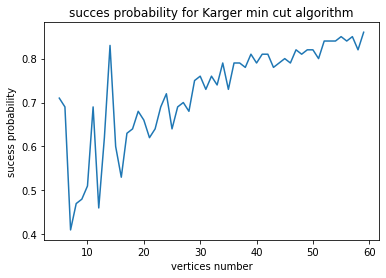

In [224]:
# Plot the execution time
plt.plot(x_os,y_os)
# Add titles and labels
plt.title('succes probability for Karger min cut algorithm')
plt.xlabel('vertices number')
plt.ylabel('sucess probability')

# Show the figure
plt.show()

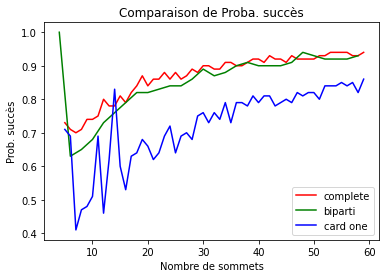

In [225]:
# Analyse des perf sur les familles de graphes

# Plotting both the curves simultaneously
plt.plot(x_cs, y_cs, color='r', label='complete')
plt.plot(x_bs, y_bs, color='g', label='biparti')
plt.plot(x_os, y_os, color='b', label='card one')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Nombre de sommets")
plt.ylabel("Prob. succès")
plt.title("Comparaison de Proba. succès")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()

### 2.b Implémentation de l'algorithme de Karger itéré

In [226]:
def KargerItere(M,T=1000):
    i = 0
    min_cut = np.inf
    S = []
    
    for i in range(T):
        S1, m = Karger(M)
        if m<min_cut:
            min_cut = m
            S = S1
    
    return S, min_cut

In [227]:
KargerItere(G_complete)

([0, 1, 5, 2, 7, 6, 3], 7)

### 2.c Réalisation d'une étude expérimentale sur les familles de graphe de l'exercice 1

--------------- 5  -----------------
--------------- 10  -----------------
--------------- 15  -----------------
--------------- 20  -----------------
--------------- 25  -----------------
--------------- 30  -----------------
--------------- 35  -----------------
--------------- 40  -----------------
--------------- 45  -----------------
--------------- 50  -----------------
--------------- 55  -----------------


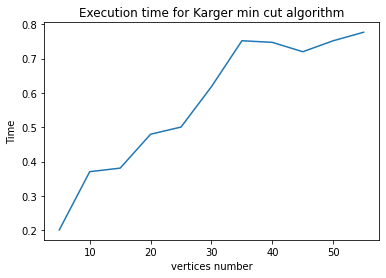

In [245]:
# Cas de graphe complet à n sommets
exec_times = []
for n in range(5, 60, 5):
    t = 0
    print(f"--------------- {n}  -----------------")
    for it in range(20):
        G = create_graph(n,'complete')
        tic = time.time()
        _,_ = KargerItere(G,T=1000)
        tac = time.time()
        t+= (tac-tic)
    exec_times.append(t/n)

# Plot the execution time
x_cit = np.arange(5,60,5)
y_cit = np.array(exec_times)

plt.plot(x,y)
# Add titles and labels
plt.title('Execution time for Karger min cut algorithm')
plt.xlabel('vertices number')
plt.ylabel('Time')

# Show the figure
plt.show()

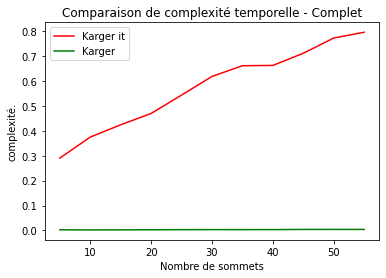

In [246]:
# Analyse des perf sur les familles de graphes

# Plotting both the curves simultaneously
plt.plot(x_cit, y_cit, color='r', label='Karger it')
plt.plot(x_cit, y_c[x_cit], color='g', label='Karger')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Nombre de sommets")
plt.ylabel("complexité.")
plt.title("Comparaison de complexité temporelle - Complet")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()

In [247]:
# Cas de graphe complet à n sommets
exec_times = []
for n in range(5, 60, 5):
    t = 0
    for it in range(20):
        G = create_graph(n,'biparti')
        tic = time.time()
        _,_ = KargerItere(G,T=1000)
        tac = time.time()
        t+= (tac-tic)
    exec_times.append(t/n)

x_bit = np.arange(5, 60, 5)
y_bit = np.array(exec_times)

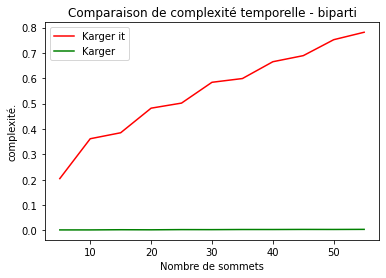

In [249]:
# Analyse des perf sur les familles de graphes

# Plotting both the curves simultaneously
plt.plot(x_bit, y_bit, color='r', label='Karger it')
plt.plot(x_bit, y_b[x_bit], color='g', label='Karger')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Nombre de sommets")
plt.ylabel("complexité.")
plt.title("Comparaison de complexité temporelle - biparti")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()

#### Notes:

- La compléxité théorique de l'algorithme de Karger itéré est de l'ordre de O(n².logn.n²) donc O(n4.logn), celle-ci est élévé par rapport à l'algorithme de Karger qui est de l'ordre de O(n²), ce résultat est confirmé par les expérimentations menées sur les différentes familles de graphes.

- La probabilité d'erreur de l'algorithme de Karger itéré est =<1/n.

### 2.d (Bonus) Exécution de l'algorithme de Karger modifié sur des familles de graphes pondérés.

In [240]:
# Créer des graphes pondérés
def create_graph_p(n_vertex,ty="random"):
    shape = (n_vertex,n_vertex)
    
    M = np.zeros(shape)
    W = np.zeros(shape)
    
    if ty=="random":
        # how to create a random graph
        # add an edge with probability p
        p = [0.2,0.8] # To be verified
        for i in range(n_vertex):
            for j in range(n_vertex):
                e = np.random.choice([0,1],1,[p])
                M[i,j] = e
                M[j,i] = e
                
                w = np.random.randint(1,50)
                
                W[i,j] = w
                W[j,i] = w
                
        np.fill_diagonal(M,0)
        np.fill_diagonal(W,0)
    elif ty=="complete":
        for i in range(n_vertex):
            for j in range(n_vertex):
                w = np.random.randint(1,50)
                W[i,j] = w
                W[j,i] = w
    else:
        print('enter a valid graph type')
        return
    
    np.fill_diagonal(M,0)
    np.fill_diagonal(W,0)
    return M.astype(int),W.astype(int)

In [241]:
M, W = create_graph_p(6,ty="random")
W

array([[ 0,  5, 27, 23, 20, 34],
       [ 5,  0, 10, 33, 41, 41],
       [27, 10,  0, 25, 39, 13],
       [23, 33, 25,  0, 22, 41],
       [20, 41, 39, 22,  0, 18],
       [34, 41, 13, 41, 18,  0]])

---------------5-----------------
---------------10-----------------
---------------15-----------------
---------------20-----------------
---------------25-----------------
---------------30-----------------
---------------35-----------------
---------------40-----------------
---------------45-----------------
---------------50-----------------
---------------55-----------------
---------------60-----------------
---------------65-----------------
---------------70-----------------
---------------75-----------------


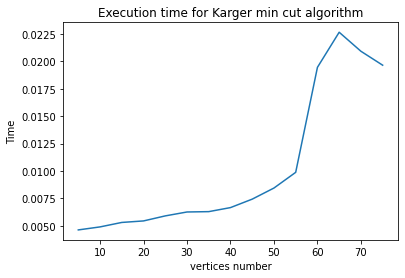

In [242]:
# Cas de graphe complet à n sommets
exec_times = []
for n in range(5, 80, 5):
    t = 0
    print(f"---------------{n}-----------------")
    for it in range(100):
        G,W = create_graph_p(n,'random')
        tic = time.time()
        _,_,_ = Karger_p(G,W)
        tac = time.time()
        t+= (tac-tic)
    exec_times.append(t/n)
# Plot the execution time
x_cp = np.arange(5,80,5)
y_cp = np.array(exec_times)

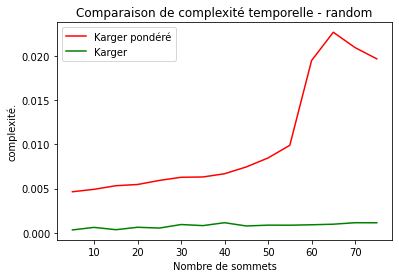

In [243]:
# Analyse des perf sur les familles de graphes

# Plotting both the curves simultaneously
plt.plot(x_cp, y_cp, color='r', label='Karger pondéré')
plt.plot(x_cp, y_r[x_cp], color='g', label='Karger')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Nombre de sommets")
plt.ylabel("complexité.")
plt.title("Comparaison de complexité temporelle - random")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()

---

## Exercice 03:

### Les questions de démonstrations a, b et c sont rédigés dans le fichier exo3.pdf soumis avec le dossier du projet.

### 3.d Implémentation de la fonction de contraction parteille.

En effet, cette fonction diffère légèrement de la fonction contract implémenté au premier exercice, et la différence réside dans le fait de supprimer la ligne et colonne du deuxième sommet de l'arête qu'on a tiré aléatoirement au lieu de remlacer par des -1.

In [45]:
def ContractionPartielle(G, t):
    # Init
    A = G.copy()
    
    sum_lines = np.sum(A,axis=1)
    nb_vertex = A.shape[0]
    
    # While the number of vertex is higher than 2
    while nb_vertex > t :
        # An inner loop to avoid choosing an edge that has
        # a negative value in the adjacency matrix
        # This is taking a lot of time when the matrix is high dimensional
        while True : 
            val,i,j = arrete_choice(A, sum_lines)
            # print(val, i,j)
            if val>0:
                break
                
        # realises a contraction on the edge (i,j)
        A = contract(A,i,j)
        
        A = np.delete(A, j, axis=0)
        A = np.delete(A, j, axis=1)
        
        ## Update of the data structures
        
        # Update the sum_lines list
        #sum_lines[i] += sum_lines[j] - val
        sum_lines[i] += sum_lines[j]
        sum_lines[i] -= 2*val
        sum_lines = np.delete(sum_lines,j)
        # We have merged two vertex
        nb_vertex-=1
            
    
    return A

# TEST
A = M.copy()
A_ = ContractionPartielle(A, 4)
A_

array([[0, 2, 1, 0],
       [2, 0, 1, 0],
       [1, 1, 0, 1],
       [0, 0, 1, 0]])

### Implémentation de l'algo KargerStein type diviser pour règner

In [87]:
def KargerStein(G):
    m = np.inf
    
    if G.shape[0]<=6:
        return Karger(G)
    
    else:
        t = int(1 + G.shape[0]/2)
        
        G1 = ContractionPartielle(G,t)
        S1,m1 = KargerStein(G1)
        
        G2 = ContractionPartielle(G,t)
        S2,m2 = KargerStein(G2)
        
        if m1<m2:
            return S1,m1
        else:
            return S2,m2
        
G = create_graph(10, ty='complete')
KargerStein(G)

([0, 1, 2, 5, 3], 9)

In [88]:
# Fonction de calcul de la probabilité de succès de l'algorithme KargerStein
def p_succes_Stein(G, min_cut, T=1000):
    
    n = 0
    for i in range(T):
        _, m = KargerStein(G)
        n += 1 if m==min_cut else 0
    return round(n/T,2)


In [89]:
KargerSteinItere(G)

([1], 9)

### Analyse expérimentale de la complexité de l'algorithme KargerStein:

In [244]:
# Cas de graphe complet à n sommets
exec_times = []
for n in range(5, 120, 5):
    t = 0
    print(f"--------------- {n} -----------------")
    for it in range(100):
        G = create_graph(n,'complete')
        tic = time.time()
        _,_ = KargerStein(G)
        tac = time.time()
        t+= (tac-tic)
    exec_times.append(t/n)

# Plot the execution time
x_cks = np.arange(5,120,5)
y_cks = np.array(exec_times)

--------------- 5 -----------------
--------------- 10 -----------------
--------------- 15 -----------------
--------------- 20 -----------------
--------------- 25 -----------------
--------------- 30 -----------------
--------------- 35 -----------------
--------------- 40 -----------------
--------------- 45 -----------------
--------------- 50 -----------------
--------------- 55 -----------------
--------------- 60 -----------------
--------------- 65 -----------------
--------------- 70 -----------------
--------------- 75 -----------------
--------------- 80 -----------------
--------------- 85 -----------------
--------------- 90 -----------------
--------------- 95 -----------------
--------------- 100 -----------------
--------------- 105 -----------------
--------------- 110 -----------------
--------------- 115 -----------------


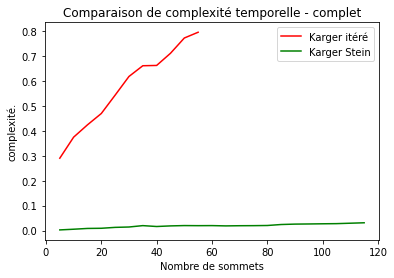

In [259]:
# Analyse des perf sur les familles de graphes

# Plotting both the curves simultaneously
plt.plot(x_cit, y_cit, color='r', label='Karger itéré')
plt.plot(x_cks, y_cks, color='g', label='Karger Stein')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Nombre de sommets")
plt.ylabel("complexité.")
plt.title("Comparaison de complexité temporelle - complet")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()

In [257]:
# Cas de graphe complet à n sommets
exec_times = []
for n in range(5, 120, 5):
    t = 0
    print(f"--------------- {n} -----------------")
    for it in range(100):
        G = create_graph(n,'biparti')
        tic = time.time()
        _,_ = KargerStein(G)
        tac = time.time()
        t+= (tac-tic)
    exec_times.append(t/n)

# Plot the execution time
x_bks = np.arange(5,120,5)
y_bks = np.array(exec_times)

--------------- 5 -----------------
--------------- 10 -----------------
--------------- 15 -----------------
--------------- 20 -----------------
--------------- 25 -----------------
--------------- 30 -----------------
--------------- 35 -----------------
--------------- 40 -----------------
--------------- 45 -----------------
--------------- 50 -----------------
--------------- 55 -----------------
--------------- 60 -----------------
--------------- 65 -----------------
--------------- 70 -----------------
--------------- 75 -----------------
--------------- 80 -----------------
--------------- 85 -----------------
--------------- 90 -----------------
--------------- 95 -----------------
--------------- 100 -----------------
--------------- 105 -----------------
--------------- 110 -----------------
--------------- 115 -----------------


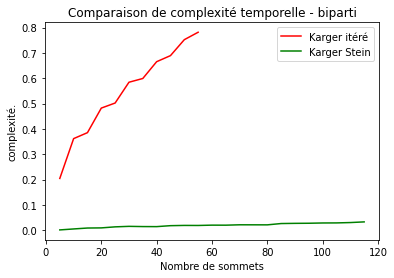

In [258]:
# Analyse des perf sur les familles de graphes

# Plotting both the curves simultaneously
plt.plot(x_bit, y_bit, color='r', label='Karger itéré')
plt.plot(x_bks, y_bks, color='g', label='Karger Stein')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Nombre de sommets")
plt.ylabel("complexité.")
plt.title("Comparaison de complexité temporelle - biparti")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()

### Analyse:
L'algorithme de Karger Stein est remarquablement plus performant que l'algorithme de Karger itérée en terme de complexité temporelle.

Ceci confirme les résultats donnés en cours et dans la question 3.a, affirmant que la complexité de la'algorithme de Karger itéré est de l'ordre de O(n4.logn) et que l'algorithme de Karger Stein est de l'ordre de O(n².logn).

### Analyse de la probabilité de succès de l'algorithme de KargerStein et le comparer à l'algorithme de Karger itéré.

La borne inférieure de la probabilité de succès de l'algorithme de KargerStein est : 1/log(n)

In [262]:
# Cas de graphe complet à n sommets
succes_ck = []
succes_cks = []
for n in range(5, 60, 5):
    print(f'Graphe avec {n}  sommets.')
    G = create_graph(n,'complete')
    succes_ck.append(p_succes(G,min_cut=G.shape[0]-1))
    succes_cks.append(p_succes_Stein(G,min_cut=G.shape[0]-1))

x_s = np.arange(5,60,5)

Graphe avec 5  sommets.
Graphe avec 10  sommets.
Graphe avec 15  sommets.
Graphe avec 20  sommets.
Graphe avec 25  sommets.
Graphe avec 30  sommets.
Graphe avec 35  sommets.
Graphe avec 40  sommets.
Graphe avec 45  sommets.
Graphe avec 50  sommets.
Graphe avec 55  sommets.


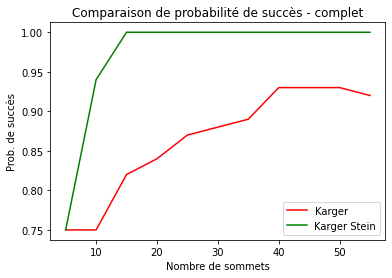

In [263]:
# Analyse des perf sur les familles de graphes

# Plotting both the curves simultaneously
plt.plot(x_s, succes_ck, color='r', label='Karger')
plt.plot(x_s, succes_cks, color='g', label='Karger Stein')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Nombre de sommets")
plt.ylabel("Prob. de succès")
plt.title("Comparaison de probabilité de succès - complet")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()

In [266]:
# Cas de graphe complet à n sommets
succes_bk = []
succes_bks = []
for n in range(4, 60, 4):
    print(f'Graphe avec {n}  sommets.')
    G = create_graph(n,'biparti')
    succes_bk.append(p_succes(G,min_cut=G.shape[0]/2))
    succes_bks.append(p_succes_Stein(G,min_cut=G.shape[0]/2))

Graphe avec 4  sommets.
Graphe avec 8  sommets.
Graphe avec 12  sommets.
Graphe avec 16  sommets.
Graphe avec 20  sommets.
Graphe avec 24  sommets.
Graphe avec 28  sommets.
Graphe avec 32  sommets.
Graphe avec 36  sommets.
Graphe avec 40  sommets.
Graphe avec 44  sommets.
Graphe avec 48  sommets.
Graphe avec 52  sommets.
Graphe avec 56  sommets.


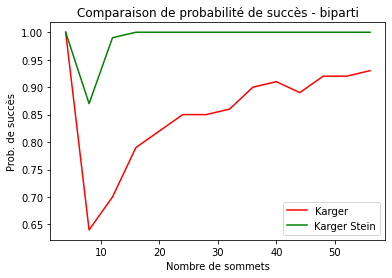

In [267]:
# Analyse des perf sur les familles de graphes
x_s = np.arange(4,60,4)
# Plotting both the curves simultaneously
plt.plot(x_s, succes_bk, color='r', label='Karger')
plt.plot(x_s, succes_bks, color='g', label='Karger Stein')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Nombre de sommets")
plt.ylabel("Prob. de succès")
plt.title("Comparaison de probabilité de succès - biparti")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()

In [271]:
# Cas de graphe complet à n sommets
succes_ok = []
succes_oks = []
for n in range(5, 60, 5):
    print(f'Graphe avec {n}  sommets.')
    G = create_graph(n,'card_one')
    succes_ok.append(p_succes(G,min_cut=1))
    succes_oks.append(p_succes_Stein(G,min_cut=1))

Graphe avec 5  sommets.
Graphe avec 10  sommets.
Graphe avec 15  sommets.
Graphe avec 20  sommets.
Graphe avec 25  sommets.
Graphe avec 30  sommets.
Graphe avec 35  sommets.
Graphe avec 40  sommets.
Graphe avec 45  sommets.
Graphe avec 50  sommets.
Graphe avec 55  sommets.


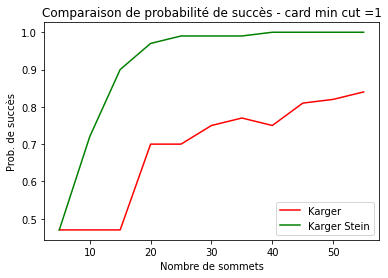

In [273]:
# Analyse des perf sur les familles de graphes
x_s = np.arange(5,60,5)
# Plotting both the curves simultaneously
plt.plot(x_s, succes_ok, color='r', label='Karger')
plt.plot(x_s, succes_oks, color='g', label='Karger Stein')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Nombre de sommets")
plt.ylabel("Prob. de succès")
plt.title("Comparaison de probabilité de succès - card min cut =1")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()

---

---